# Classifying Chest X-rays with Cross-Modal Data Programming

This tutorial demonstrates how to use the *cross-modal data programming* technique described in Dunnmon and Ratner, et al. (2019) to build a Convolutional Neural Network (CNN) model with no hand-labeled data that performs similarly to a CNN supervised using several thousand data points labeled by radiologists.  This process is *exactly* equivalent to that followed for the chest radiograph dataset in our 2019 Nature submission.

We begin by setting up our environment, importing relevant Python packages.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
# Making sure CUDA devices are visible!
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Importing pandas for data processing
import pandas as pd

## Step 1: Loading and Splitting the Data

First, we set up the data dictionary and load data that we've already split for you into an (approximately) 80% train split, 10% development split, and 10% test split.  Each raw data point contains three fields: a text report, a label (normal or abnormal), and a set of image paths.  The original data, from the OpenI dataset, is maintained by [NIH](https://openi.nlm.nih.gov/faq.php).

In [2]:
# Setting up data dictionary and defining data splits
data = {}
splits = ['train','dev','test']

for split in splits:
    data[split] = pd.read_csv(f'data/{split}_entries.csv')[['label','xray_paths','text']]
    # Adjusting labels to fit with Snorkel MeTaL labeling convention
    data[split]['label'][data[split]['label']==0] = 2
    perc_pos = sum(data[split]['label']==1)/len(data[split])
    print(f'{len(data[split])} {split} examples: {100*perc_pos:0.1f}% Abnormal')

2630 train examples: 63.8% Abnormal
376 dev examples: 63.0% Abnormal
378 test examples: 61.6% Abnormal


You can see an example of a single data point below -- note that the raw label convention for our normal vs. abnormal classification problem is 1 for abnormal and 2 for abnormal.

In [3]:
sample = data['train'].iloc[0]
print('RAW TEXT:\n \n',sample['text'],'\n')
print('IMAGE PATHS: \n \n', sample['xray_paths'],'\n')
print('LABEL:', sample['label'])

RAW TEXT:
 
 COMPARISON: Chest x-XXXX XXXX INDICATION: XXXX in bathtub FINDINGS: The lungs and pleural spaces show no acute abnormality. Hyperexpanded lungs. Calcified right upper lobe granuloma, unchanged. Heart size and pulmonary vascularity within normal limits. No displaced rib fractures. IMPRESSION: 1. Hyperexpansion without acute pulmonary abnormality. 

IMAGE PATHS: 
 
 ./data/openi/xrays/CXR2824_IM-1245-13001.png 

LABEL: 1


## Step 2: Developing LFs

We now define our *labeling functions* (LFs): simple, heuristic functions written by a domain expert (e.g., a radiologist) that correctly label a report as normal or abnormal with probability better than random chance.  

We give an example of all three types of LFs we reference in the paper: general pattern LFs that operate on patterns a non-expert user could easily identify, medical pattern LFs that operate on patterns easily identifiable by a clinician, and structural LFs that focus on specific structural elements of the report (e.g. how long it is) that have some correlation with the scan it describes being normal or abnormal.

In [4]:
import re

# Value to use for abstain votes
ABSTAIN = 0
# Value to use for abnormal votes
ABNORMAL = 1
# Value to user for normal votes
NORMAL = 2

# Example of a General Pattern LF
def LF_is_seen_or_noted_in_report_demo(report):
    if any(word in report.lower() for word in ["is seen", "noted"]):
        return ABNORMAL
    else:
        return ABSTAIN

# Example of a Medical Pattern LF
def LF_lung_hyperdistention_demo(report):
    """
    Votes abnormal for indications of lung hyperdistention.
    """
    reg_01 = re.compile("increased volume|hyperexpan|inflated", re.IGNORECASE)
    for s in report.split("."):
        if reg_01.search(s):
            return ABNORMAL
    ### *** ###
    return NORMAL

# Example of a Structural LF
def LF_report_is_short_demo(report):
    """
    Checks if report is short.
    """
    return NORMAL if len(report) < 280 else ABSTAIN

Now, we can see how well these LFs might do at correctly indicating normal or abnormal examples.  Check them out by changing the `lf_test` function in the cell below to reference one of those listed above. 

In [5]:
import numpy as np
from metal.analysis import single_lf_summary, confusion_matrix

# Testing single LF
lf_test = LF_lung_hyperdistention_demo

# Computing labels
Y_lf = np.array([lf_test(doc['text']) for ind, doc in data['dev'].iterrows()])
Y_dev = np.array([doc['label'] for ind, doc in data['dev'].iterrows()])

# Summarizing LF performance
single_lf_summary(Y_lf, Y=Y_dev)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",1.0,0.0,0.0,168,208,0.446809


If we use analyze the `LF_lung_hyperdistention_demo` function -- in this case,  we see that it has polarity [1,2], meaning it votes on both class 1 and class 2 (and votes on every example because `coverage` = 1.0), but that it has low accuracy (around 44%).  Let's look at the confusion matrix to see why. 

In [6]:
# Print confusion matrix
conf = confusion_matrix(Y_dev, Y_lf)

        y=1    y=2   
 l=1    32      3    
 l=2    205    136   


Clearly, this LF is much more accurate on abnormal examples (where y=1) than on abnormal examples (where y=2).  Why don't we adjust it to only vote in the positive direction and see how we do?  

Go ahead and change `NORMAL` to `ABSTAIN` in the `LF_lung_hyperdistention_demo` function (the line below the `### *** ###` comment), and rerun the last three code cells.  

You'll see that by making this rule a bit more targeted, its coverage decreases to 9%, but it's accuracy jumps to over 90%.  This type of iteration is exactly how clinicians can develop LFs in practice.

You may also notice that it's very easy to write these LFs over text, but it would be very hard to, say, write an `LF_lung_hyperdistention` version that operates over an image -- this is why cross-modality is so important!

## Step 3: Computing the Label Matrix

Once we've designed a couple of LFs, it's time to execute them all on every example we have to create a *label matrix*.  This is an $n$ by $m$ matrix, where $n$ is the number of examples and $m$ is the number of LFs.  

In [7]:
from labeling_functions import *

lfs = [
    LF_report_is_short,
    LF_consistency_in_report,
    LF_negative_inflection_words_in_report,
    LF_is_seen_or_noted_in_report,
    LF_disease_in_report,
    LF_abnormal_mesh_terms_in_report,
    LF_recommend_in_report,
    LF_mm_in_report,
    LF_normal,
    LF_positive_MeshTerm,
    LF_fracture,
    LF_calcinosis,
    LF_degen_spine,
    LF_lung_hypoinflation,
    LF_lung_hyperdistention,
    LF_catheters,
    LF_surgical,
    LF_granuloma,
]

Now we define a few simple helper functions for running our labeling functions over all text reports.

In [8]:
import dask
from dask.diagnostics import ProgressBar
from scipy.sparse import csr_matrix

def evaluate_lf_on_docs(docs, lf):
    """
    Evaluates lf on list of documents
    """
    
    lf_list = []
    for doc in docs:
        lf_list.append(lf(doc))
    return lf_list

def create_label_matrix(lfs, docs):
    """
    Creates label matrix from documents and lfs
    """
    
    delayed_lf_rows = []
    
    for lf in lfs:
        delayed_lf_rows.append(dask.delayed(evaluate_lf_on_docs)(docs, lf))

    with ProgressBar():
        L = csr_matrix(np.vstack(dask.compute(*delayed_lf_rows)).transpose())  
    
    return L

Now, we simply apply each of our LFs to each of our reports.

In [9]:
# Get lf names
lf_names = [lf.__name__ for lf in lfs]

# Allocating label matrix and ground truth label lists
Ls = []
Ys = []

# Computing lfs
print('Computing label matrices...')
for i, docs in enumerate((
    data['train']['text'].tolist(), 
    data['dev']['text'].tolist(), 
    data['test']['text'].tolist()
    )
):
    Ls.append(create_label_matrix(lfs,docs))  

# Getting ground truth labels
print('Creating label vectors...')
Ys = [data['train']['label'].tolist(),
      data['dev']['label'].tolist(),
      data['test']['label'].tolist()]

Computing label matrices...
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
Creating label vectors...


Now that we've done this, we can inspect our accuracy on the development set and other useful LF metrics using the simple MeTaL interface.

In [10]:
from metal.analysis import lf_summary

# Analyzing LF stats
lf_summary(Ls[1], Y=Y_dev, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_report_is_short,0,2,0.303191,0.303191,0.207447,72,42,0.631579
LF_consistency_in_report,1,"[1, 2]",1.000000,0.928191,0.401596,305,71,0.811170
LF_negative_inflection_words_in_report,2,1,0.082447,0.082447,0.029255,30,1,0.967742
LF_is_seen_or_noted_in_report,3,1,0.085106,0.085106,0.026596,25,7,0.781250
LF_disease_in_report,4,1,0.372340,0.372340,0.175532,89,51,0.635714
LF_abnormal_mesh_terms_in_report,5,1,0.417553,0.417553,0.138298,141,16,0.898089
LF_recommend_in_report,6,1,0.015957,0.015957,0.002660,6,0,1.000000
LF_mm_in_report,7,1,0.053191,0.053191,0.010638,20,0,1.000000
LF_normal,8,2,0.159574,0.159574,0.114362,34,26,0.566667
LF_positive_MeshTerm,9,1,0.295213,0.295213,0.106383,108,3,0.972973


Note that all of our labeling functions, while certainly imperfect, are better than random chance.  This fulfills the only theoretical requirement of the cross-modal data programming algorithm.  

We can also get a sense of where the LFs overlap and conflict by inspecting the following plot; it is critical that some of the LFs overlap or conflict, or else we would not have any signal to learn their accuracies.

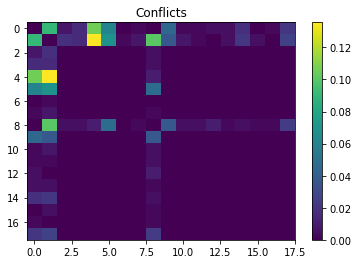

In [11]:
from  metal.contrib.visualization.analysis import view_conflicts

# Viewing conflicts
view_conflicts(Ls[1], normalize=True)

## Step 4: Train a Label Model in Snorkel MeTaL

Next, we use the Snorkel MeTaL model training API to train a `LabelModel` that learns the accuracies of our LFs.  This is the core step that the data programming technique simplifies and formalizes -- by combining our labeling functions based on their accuracies, we can recover a model that outputs reasonable weak labels.

We perform a simple random hyperparameter search over learning rate and L2 regularization, using our small labeled development set to choose the best model.  

In [12]:
from metal.label_model import LabelModel
from metal.logging import LogWriter
from metal.tuners import RandomSearchTuner

# Creating search space
search_space = {
        'l2': {'range': [0.0001, 0.1], 'scale':'log'},           # linear range
        'lr': {'range': [0.0001, 0.1], 'scale': 'log'},  # log range
        }

searcher = RandomSearchTuner(LabelModel, log_dir='./run_logs',
            log_writer_class=None)

# Training label model
label_model = searcher.search(search_space, (Ls[1],Ys[1]), \
        train_args=[Ls[0]], init_args=[],
        init_kwargs={'k':2, 'seed':1701}, 
        train_kwargs={'n_epochs':200},
        max_search=40,
        verbose=True)

[0] Testing {'l2': 0.03414016019207298, 'lr': 0.018787249753397045}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.950]
[2 epo]: TRAIN:[loss=1.906]
[3 epo]: TRAIN:[loss=1.822]
[4 epo]: TRAIN:[loss=1.697]
[5 epo]: TRAIN:[loss=1.533]
[6 epo]: TRAIN:[loss=1.331]
[7 epo]: TRAIN:[loss=1.094]
[8 epo]: TRAIN:[loss=0.834]
[9 epo]: TRAIN:[loss=0.571]
[10 epo]: TRAIN:[loss=0.339]
[11 epo]: TRAIN:[loss=0.179]
[12 epo]: TRAIN:[loss=0.130]
[13 epo]: TRAIN:[loss=0.198]
[14 epo]: TRAIN:[loss=0.346]
[15 epo]: TRAIN:[loss=0.492]
[16 epo]: TRAIN:[loss=0.556]
[17 epo]: TRAIN:[loss=0.511]
[18 epo]: TRAIN:[loss=0.391]
[19 epo]: TRAIN:[loss=0.259]
[20 epo]: TRAIN:[loss=0.165]
[21 epo]: TRAIN:[loss=0.127]
[22 epo]: TRAIN:[loss=0.136]
[23 epo]: TRAIN:[loss=0.170]
[24 epo]: TRAIN:[loss=0.209]
[25 epo]: TRAIN:[loss=0.239]
[26 epo]: TRAIN:[loss=0.251]
[27 epo]: TRAIN:[loss=0.244]
[28 epo]: TRAIN:[loss=0.220]
[29 epo]: TRAIN:[loss=0.186]
[30 epo]: TRAIN:[loss=0.148]
[31 epo]: TRAIN:[loss=0.114]
[32 epo]:

[137 epo]: TRAIN:[loss=0.228]
[138 epo]: TRAIN:[loss=0.224]
[139 epo]: TRAIN:[loss=0.219]
[140 epo]: TRAIN:[loss=0.214]
[141 epo]: TRAIN:[loss=0.210]
[142 epo]: TRAIN:[loss=0.206]
[143 epo]: TRAIN:[loss=0.202]
[144 epo]: TRAIN:[loss=0.198]
[145 epo]: TRAIN:[loss=0.194]
[146 epo]: TRAIN:[loss=0.191]
[147 epo]: TRAIN:[loss=0.187]
[148 epo]: TRAIN:[loss=0.184]
[149 epo]: TRAIN:[loss=0.181]
[150 epo]: TRAIN:[loss=0.178]
[151 epo]: TRAIN:[loss=0.175]
[152 epo]: TRAIN:[loss=0.172]
[153 epo]: TRAIN:[loss=0.170]
[154 epo]: TRAIN:[loss=0.167]
[155 epo]: TRAIN:[loss=0.165]
[156 epo]: TRAIN:[loss=0.162]
[157 epo]: TRAIN:[loss=0.160]
[158 epo]: TRAIN:[loss=0.158]
[159 epo]: TRAIN:[loss=0.156]
[160 epo]: TRAIN:[loss=0.154]
[161 epo]: TRAIN:[loss=0.152]
[162 epo]: TRAIN:[loss=0.151]
[163 epo]: TRAIN:[loss=0.149]
[164 epo]: TRAIN:[loss=0.147]
[165 epo]: TRAIN:[loss=0.146]
[166 epo]: TRAIN:[loss=0.144]
[167 epo]: TRAIN:[loss=0.143]
[168 epo]: TRAIN:[loss=0.141]
[169 epo]: TRAIN:[loss=0.140]
[170 epo]:

[30 epo]: TRAIN:[loss=1.538]
[31 epo]: TRAIN:[loss=1.518]
[32 epo]: TRAIN:[loss=1.497]
[33 epo]: TRAIN:[loss=1.476]
[34 epo]: TRAIN:[loss=1.455]
[35 epo]: TRAIN:[loss=1.433]
[36 epo]: TRAIN:[loss=1.412]
[37 epo]: TRAIN:[loss=1.390]
[38 epo]: TRAIN:[loss=1.368]
[39 epo]: TRAIN:[loss=1.346]
[40 epo]: TRAIN:[loss=1.324]
[41 epo]: TRAIN:[loss=1.302]
[42 epo]: TRAIN:[loss=1.280]
[43 epo]: TRAIN:[loss=1.257]
[44 epo]: TRAIN:[loss=1.235]
[45 epo]: TRAIN:[loss=1.212]
[46 epo]: TRAIN:[loss=1.190]
[47 epo]: TRAIN:[loss=1.167]
[48 epo]: TRAIN:[loss=1.145]
[49 epo]: TRAIN:[loss=1.122]
[50 epo]: TRAIN:[loss=1.100]
[51 epo]: TRAIN:[loss=1.077]
[52 epo]: TRAIN:[loss=1.054]
[53 epo]: TRAIN:[loss=1.032]
[54 epo]: TRAIN:[loss=1.009]
[55 epo]: TRAIN:[loss=0.987]
[56 epo]: TRAIN:[loss=0.965]
[57 epo]: TRAIN:[loss=0.942]
[58 epo]: TRAIN:[loss=0.920]
[59 epo]: TRAIN:[loss=0.898]
[60 epo]: TRAIN:[loss=0.876]
[61 epo]: TRAIN:[loss=0.854]
[62 epo]: TRAIN:[loss=0.833]
[63 epo]: TRAIN:[loss=0.811]
[64 epo]: TRAI

[127 epo]: TRAIN:[loss=0.026]
[128 epo]: TRAIN:[loss=0.026]
[129 epo]: TRAIN:[loss=0.026]
[130 epo]: TRAIN:[loss=0.026]
[131 epo]: TRAIN:[loss=0.025]
[132 epo]: TRAIN:[loss=0.025]
[133 epo]: TRAIN:[loss=0.025]
[134 epo]: TRAIN:[loss=0.025]
[135 epo]: TRAIN:[loss=0.025]
[136 epo]: TRAIN:[loss=0.025]
[137 epo]: TRAIN:[loss=0.024]
[138 epo]: TRAIN:[loss=0.024]
[139 epo]: TRAIN:[loss=0.024]
[140 epo]: TRAIN:[loss=0.024]
[141 epo]: TRAIN:[loss=0.024]
[142 epo]: TRAIN:[loss=0.024]
[143 epo]: TRAIN:[loss=0.024]
[144 epo]: TRAIN:[loss=0.024]
[145 epo]: TRAIN:[loss=0.024]
[146 epo]: TRAIN:[loss=0.024]
[147 epo]: TRAIN:[loss=0.024]
[148 epo]: TRAIN:[loss=0.024]
[149 epo]: TRAIN:[loss=0.024]
[150 epo]: TRAIN:[loss=0.024]
[151 epo]: TRAIN:[loss=0.024]
[152 epo]: TRAIN:[loss=0.024]
[153 epo]: TRAIN:[loss=0.024]
[154 epo]: TRAIN:[loss=0.024]
[155 epo]: TRAIN:[loss=0.024]
[156 epo]: TRAIN:[loss=0.024]
[157 epo]: TRAIN:[loss=0.023]
[158 epo]: TRAIN:[loss=0.023]
[159 epo]: TRAIN:[loss=0.023]
[160 epo]:

[200 epo]: TRAIN:[loss=0.028]
Finished Training
[6] Testing {'l2': 0.0007006700163436134, 'lr': 0.018510263983441404}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.905]
[3 epo]: TRAIN:[loss=1.822]
[4 epo]: TRAIN:[loss=1.700]
[5 epo]: TRAIN:[loss=1.539]
[6 epo]: TRAIN:[loss=1.340]
[7 epo]: TRAIN:[loss=1.107]
[8 epo]: TRAIN:[loss=0.851]
[9 epo]: TRAIN:[loss=0.590]
[10 epo]: TRAIN:[loss=0.356]
[11 epo]: TRAIN:[loss=0.190]
[12 epo]: TRAIN:[loss=0.128]
[13 epo]: TRAIN:[loss=0.183]
[14 epo]: TRAIN:[loss=0.323]
[15 epo]: TRAIN:[loss=0.471]
[16 epo]: TRAIN:[loss=0.548]
[17 epo]: TRAIN:[loss=0.518]
[18 epo]: TRAIN:[loss=0.408]
[19 epo]: TRAIN:[loss=0.276]
[20 epo]: TRAIN:[loss=0.176]
[21 epo]: TRAIN:[loss=0.130]
[22 epo]: TRAIN:[loss=0.131]
[23 epo]: TRAIN:[loss=0.161]
[24 epo]: TRAIN:[loss=0.199]
[25 epo]: TRAIN:[loss=0.231]
[26 epo]: TRAIN:[loss=0.247]
[27 epo]: TRAIN:[loss=0.244]
[28 epo]: TRAIN:[loss=0.225]
[29 epo]: TRAIN:[loss=0.193]
[30 epo]: TRAIN:[

[96 epo]: TRAIN:[loss=0.671]
[97 epo]: TRAIN:[loss=0.658]
[98 epo]: TRAIN:[loss=0.644]
[99 epo]: TRAIN:[loss=0.631]
[100 epo]: TRAIN:[loss=0.618]
[101 epo]: TRAIN:[loss=0.605]
[102 epo]: TRAIN:[loss=0.593]
[103 epo]: TRAIN:[loss=0.580]
[104 epo]: TRAIN:[loss=0.568]
[105 epo]: TRAIN:[loss=0.556]
[106 epo]: TRAIN:[loss=0.544]
[107 epo]: TRAIN:[loss=0.532]
[108 epo]: TRAIN:[loss=0.520]
[109 epo]: TRAIN:[loss=0.509]
[110 epo]: TRAIN:[loss=0.498]
[111 epo]: TRAIN:[loss=0.487]
[112 epo]: TRAIN:[loss=0.476]
[113 epo]: TRAIN:[loss=0.465]
[114 epo]: TRAIN:[loss=0.455]
[115 epo]: TRAIN:[loss=0.445]
[116 epo]: TRAIN:[loss=0.434]
[117 epo]: TRAIN:[loss=0.425]
[118 epo]: TRAIN:[loss=0.415]
[119 epo]: TRAIN:[loss=0.406]
[120 epo]: TRAIN:[loss=0.396]
[121 epo]: TRAIN:[loss=0.387]
[122 epo]: TRAIN:[loss=0.378]
[123 epo]: TRAIN:[loss=0.370]
[124 epo]: TRAIN:[loss=0.361]
[125 epo]: TRAIN:[loss=0.353]
[126 epo]: TRAIN:[loss=0.345]
[127 epo]: TRAIN:[loss=0.337]
[128 epo]: TRAIN:[loss=0.329]
[129 epo]: TRA

[168 epo]: TRAIN:[loss=0.024]
[169 epo]: TRAIN:[loss=0.024]
[170 epo]: TRAIN:[loss=0.024]
[171 epo]: TRAIN:[loss=0.024]
[172 epo]: TRAIN:[loss=0.024]
[173 epo]: TRAIN:[loss=0.024]
[174 epo]: TRAIN:[loss=0.024]
[175 epo]: TRAIN:[loss=0.024]
[176 epo]: TRAIN:[loss=0.024]
[177 epo]: TRAIN:[loss=0.024]
[178 epo]: TRAIN:[loss=0.024]
[179 epo]: TRAIN:[loss=0.024]
[180 epo]: TRAIN:[loss=0.024]
[181 epo]: TRAIN:[loss=0.024]
[182 epo]: TRAIN:[loss=0.024]
[183 epo]: TRAIN:[loss=0.024]
[184 epo]: TRAIN:[loss=0.024]
[185 epo]: TRAIN:[loss=0.024]
[186 epo]: TRAIN:[loss=0.024]
[187 epo]: TRAIN:[loss=0.024]
[188 epo]: TRAIN:[loss=0.024]
[189 epo]: TRAIN:[loss=0.024]
[190 epo]: TRAIN:[loss=0.024]
[191 epo]: TRAIN:[loss=0.024]
[192 epo]: TRAIN:[loss=0.024]
[193 epo]: TRAIN:[loss=0.024]
[194 epo]: TRAIN:[loss=0.024]
[195 epo]: TRAIN:[loss=0.024]
[196 epo]: TRAIN:[loss=0.024]
[197 epo]: TRAIN:[loss=0.024]
[198 epo]: TRAIN:[loss=0.024]
[199 epo]: TRAIN:[loss=0.024]
[200 epo]: TRAIN:[loss=0.024]
Finished T

[60 epo]: TRAIN:[loss=0.025]
[61 epo]: TRAIN:[loss=0.025]
[62 epo]: TRAIN:[loss=0.026]
[63 epo]: TRAIN:[loss=0.027]
[64 epo]: TRAIN:[loss=0.028]
[65 epo]: TRAIN:[loss=0.028]
[66 epo]: TRAIN:[loss=0.028]
[67 epo]: TRAIN:[loss=0.027]
[68 epo]: TRAIN:[loss=0.027]
[69 epo]: TRAIN:[loss=0.026]
[70 epo]: TRAIN:[loss=0.025]
[71 epo]: TRAIN:[loss=0.025]
[72 epo]: TRAIN:[loss=0.025]
[73 epo]: TRAIN:[loss=0.025]
[74 epo]: TRAIN:[loss=0.025]
[75 epo]: TRAIN:[loss=0.025]
[76 epo]: TRAIN:[loss=0.025]
[77 epo]: TRAIN:[loss=0.024]
[78 epo]: TRAIN:[loss=0.024]
[79 epo]: TRAIN:[loss=0.024]
[80 epo]: TRAIN:[loss=0.024]
[81 epo]: TRAIN:[loss=0.023]
[82 epo]: TRAIN:[loss=0.023]
[83 epo]: TRAIN:[loss=0.023]
[84 epo]: TRAIN:[loss=0.023]
[85 epo]: TRAIN:[loss=0.023]
[86 epo]: TRAIN:[loss=0.023]
[87 epo]: TRAIN:[loss=0.023]
[88 epo]: TRAIN:[loss=0.023]
[89 epo]: TRAIN:[loss=0.023]
[90 epo]: TRAIN:[loss=0.023]
[91 epo]: TRAIN:[loss=0.023]
[92 epo]: TRAIN:[loss=0.023]
[93 epo]: TRAIN:[loss=0.023]
[94 epo]: TRAI

[137 epo]: TRAIN:[loss=0.024]
[138 epo]: TRAIN:[loss=0.024]
[139 epo]: TRAIN:[loss=0.024]
[140 epo]: TRAIN:[loss=0.024]
[141 epo]: TRAIN:[loss=0.024]
[142 epo]: TRAIN:[loss=0.024]
[143 epo]: TRAIN:[loss=0.024]
[144 epo]: TRAIN:[loss=0.024]
[145 epo]: TRAIN:[loss=0.024]
[146 epo]: TRAIN:[loss=0.024]
[147 epo]: TRAIN:[loss=0.024]
[148 epo]: TRAIN:[loss=0.024]
[149 epo]: TRAIN:[loss=0.024]
[150 epo]: TRAIN:[loss=0.024]
[151 epo]: TRAIN:[loss=0.024]
[152 epo]: TRAIN:[loss=0.024]
[153 epo]: TRAIN:[loss=0.024]
[154 epo]: TRAIN:[loss=0.024]
[155 epo]: TRAIN:[loss=0.024]
[156 epo]: TRAIN:[loss=0.024]
[157 epo]: TRAIN:[loss=0.024]
[158 epo]: TRAIN:[loss=0.024]
[159 epo]: TRAIN:[loss=0.024]
[160 epo]: TRAIN:[loss=0.024]
[161 epo]: TRAIN:[loss=0.024]
[162 epo]: TRAIN:[loss=0.024]
[163 epo]: TRAIN:[loss=0.024]
[164 epo]: TRAIN:[loss=0.024]
[165 epo]: TRAIN:[loss=0.024]
[166 epo]: TRAIN:[loss=0.024]
[167 epo]: TRAIN:[loss=0.024]
[168 epo]: TRAIN:[loss=0.024]
[169 epo]: TRAIN:[loss=0.024]
[170 epo]:

[37 epo]: TRAIN:[loss=0.123]
[38 epo]: TRAIN:[loss=0.115]
[39 epo]: TRAIN:[loss=0.112]
[40 epo]: TRAIN:[loss=0.113]
[41 epo]: TRAIN:[loss=0.115]
[42 epo]: TRAIN:[loss=0.119]
[43 epo]: TRAIN:[loss=0.123]
[44 epo]: TRAIN:[loss=0.126]
[45 epo]: TRAIN:[loss=0.128]
[46 epo]: TRAIN:[loss=0.128]
[47 epo]: TRAIN:[loss=0.128]
[48 epo]: TRAIN:[loss=0.126]
[49 epo]: TRAIN:[loss=0.123]
[50 epo]: TRAIN:[loss=0.119]
[51 epo]: TRAIN:[loss=0.115]
[52 epo]: TRAIN:[loss=0.110]
[53 epo]: TRAIN:[loss=0.106]
[54 epo]: TRAIN:[loss=0.102]
[55 epo]: TRAIN:[loss=0.099]
[56 epo]: TRAIN:[loss=0.096]
[57 epo]: TRAIN:[loss=0.094]
[58 epo]: TRAIN:[loss=0.093]
[59 epo]: TRAIN:[loss=0.092]
[60 epo]: TRAIN:[loss=0.091]
[61 epo]: TRAIN:[loss=0.090]
[62 epo]: TRAIN:[loss=0.090]
[63 epo]: TRAIN:[loss=0.089]
[64 epo]: TRAIN:[loss=0.088]
[65 epo]: TRAIN:[loss=0.087]
[66 epo]: TRAIN:[loss=0.085]
[67 epo]: TRAIN:[loss=0.084]
[68 epo]: TRAIN:[loss=0.082]
[69 epo]: TRAIN:[loss=0.080]
[70 epo]: TRAIN:[loss=0.078]
[71 epo]: TRAI

[119 epo]: TRAIN:[loss=0.024]
[120 epo]: TRAIN:[loss=0.024]
[121 epo]: TRAIN:[loss=0.024]
[122 epo]: TRAIN:[loss=0.024]
[123 epo]: TRAIN:[loss=0.024]
[124 epo]: TRAIN:[loss=0.024]
[125 epo]: TRAIN:[loss=0.024]
[126 epo]: TRAIN:[loss=0.024]
[127 epo]: TRAIN:[loss=0.024]
[128 epo]: TRAIN:[loss=0.024]
[129 epo]: TRAIN:[loss=0.024]
[130 epo]: TRAIN:[loss=0.024]
[131 epo]: TRAIN:[loss=0.024]
[132 epo]: TRAIN:[loss=0.024]
[133 epo]: TRAIN:[loss=0.024]
[134 epo]: TRAIN:[loss=0.024]
[135 epo]: TRAIN:[loss=0.024]
[136 epo]: TRAIN:[loss=0.024]
[137 epo]: TRAIN:[loss=0.024]
[138 epo]: TRAIN:[loss=0.024]
[139 epo]: TRAIN:[loss=0.024]
[140 epo]: TRAIN:[loss=0.024]
[141 epo]: TRAIN:[loss=0.024]
[142 epo]: TRAIN:[loss=0.024]
[143 epo]: TRAIN:[loss=0.024]
[144 epo]: TRAIN:[loss=0.024]
[145 epo]: TRAIN:[loss=0.024]
[146 epo]: TRAIN:[loss=0.024]
[147 epo]: TRAIN:[loss=0.024]
[148 epo]: TRAIN:[loss=0.024]
[149 epo]: TRAIN:[loss=0.024]
[150 epo]: TRAIN:[loss=0.024]
[151 epo]: TRAIN:[loss=0.024]
[152 epo]:

[194 epo]: TRAIN:[loss=0.023]
[195 epo]: TRAIN:[loss=0.023]
[196 epo]: TRAIN:[loss=0.023]
[197 epo]: TRAIN:[loss=0.023]
[198 epo]: TRAIN:[loss=0.023]
[199 epo]: TRAIN:[loss=0.023]
[200 epo]: TRAIN:[loss=0.023]
Finished Training
[16] Testing {'l2': 0.0006046122347410976, 'lr': 0.02600659419586936}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.887]
[3 epo]: TRAIN:[loss=1.770]
[4 epo]: TRAIN:[loss=1.594]
[5 epo]: TRAIN:[loss=1.362]
[6 epo]: TRAIN:[loss=1.077]
[7 epo]: TRAIN:[loss=0.757]
[8 epo]: TRAIN:[loss=0.445]
[9 epo]: TRAIN:[loss=0.209]
[10 epo]: TRAIN:[loss=0.129]
[11 epo]: TRAIN:[loss=0.241]
[12 epo]: TRAIN:[loss=0.470]
[13 epo]: TRAIN:[loss=0.647]
[14 epo]: TRAIN:[loss=0.641]
[15 epo]: TRAIN:[loss=0.473]
[16 epo]: TRAIN:[loss=0.275]
[17 epo]: TRAIN:[loss=0.154]
[18 epo]: TRAIN:[loss=0.135]
[19 epo]: TRAIN:[loss=0.182]
[20 epo]: TRAIN:[loss=0.249]
[21 epo]: TRAIN:[loss=0.301]
[22 epo]: TRAIN:[loss=0.321]
[23 epo]: TRAIN:[loss=0.305]
[24 epo]: T

[59 epo]: TRAIN:[loss=1.820]
[60 epo]: TRAIN:[loss=1.817]
[61 epo]: TRAIN:[loss=1.815]
[62 epo]: TRAIN:[loss=1.812]
[63 epo]: TRAIN:[loss=1.809]
[64 epo]: TRAIN:[loss=1.807]
[65 epo]: TRAIN:[loss=1.804]
[66 epo]: TRAIN:[loss=1.801]
[67 epo]: TRAIN:[loss=1.799]
[68 epo]: TRAIN:[loss=1.796]
[69 epo]: TRAIN:[loss=1.793]
[70 epo]: TRAIN:[loss=1.790]
[71 epo]: TRAIN:[loss=1.788]
[72 epo]: TRAIN:[loss=1.785]
[73 epo]: TRAIN:[loss=1.782]
[74 epo]: TRAIN:[loss=1.780]
[75 epo]: TRAIN:[loss=1.777]
[76 epo]: TRAIN:[loss=1.774]
[77 epo]: TRAIN:[loss=1.771]
[78 epo]: TRAIN:[loss=1.769]
[79 epo]: TRAIN:[loss=1.766]
[80 epo]: TRAIN:[loss=1.763]
[81 epo]: TRAIN:[loss=1.760]
[82 epo]: TRAIN:[loss=1.758]
[83 epo]: TRAIN:[loss=1.755]
[84 epo]: TRAIN:[loss=1.752]
[85 epo]: TRAIN:[loss=1.749]
[86 epo]: TRAIN:[loss=1.747]
[87 epo]: TRAIN:[loss=1.744]
[88 epo]: TRAIN:[loss=1.741]
[89 epo]: TRAIN:[loss=1.738]
[90 epo]: TRAIN:[loss=1.736]
[91 epo]: TRAIN:[loss=1.733]
[92 epo]: TRAIN:[loss=1.730]
[93 epo]: TRAI

[153 epo]: TRAIN:[loss=0.103]
[154 epo]: TRAIN:[loss=0.103]
[155 epo]: TRAIN:[loss=0.103]
[156 epo]: TRAIN:[loss=0.103]
[157 epo]: TRAIN:[loss=0.102]
[158 epo]: TRAIN:[loss=0.102]
[159 epo]: TRAIN:[loss=0.102]
[160 epo]: TRAIN:[loss=0.102]
[161 epo]: TRAIN:[loss=0.101]
[162 epo]: TRAIN:[loss=0.101]
[163 epo]: TRAIN:[loss=0.101]
[164 epo]: TRAIN:[loss=0.101]
[165 epo]: TRAIN:[loss=0.101]
[166 epo]: TRAIN:[loss=0.100]
[167 epo]: TRAIN:[loss=0.100]
[168 epo]: TRAIN:[loss=0.100]
[169 epo]: TRAIN:[loss=0.100]
[170 epo]: TRAIN:[loss=0.099]
[171 epo]: TRAIN:[loss=0.099]
[172 epo]: TRAIN:[loss=0.099]
[173 epo]: TRAIN:[loss=0.099]
[174 epo]: TRAIN:[loss=0.098]
[175 epo]: TRAIN:[loss=0.098]
[176 epo]: TRAIN:[loss=0.098]
[177 epo]: TRAIN:[loss=0.098]
[178 epo]: TRAIN:[loss=0.097]
[179 epo]: TRAIN:[loss=0.097]
[180 epo]: TRAIN:[loss=0.097]
[181 epo]: TRAIN:[loss=0.097]
[182 epo]: TRAIN:[loss=0.096]
[183 epo]: TRAIN:[loss=0.096]
[184 epo]: TRAIN:[loss=0.096]
[185 epo]: TRAIN:[loss=0.095]
[186 epo]:

[28 epo]: TRAIN:[loss=0.513]
[29 epo]: TRAIN:[loss=0.453]
[30 epo]: TRAIN:[loss=0.398]
[31 epo]: TRAIN:[loss=0.347]
[32 epo]: TRAIN:[loss=0.301]
[33 epo]: TRAIN:[loss=0.261]
[34 epo]: TRAIN:[loss=0.226]
[35 epo]: TRAIN:[loss=0.197]
[36 epo]: TRAIN:[loss=0.173]
[37 epo]: TRAIN:[loss=0.155]
[38 epo]: TRAIN:[loss=0.141]
[39 epo]: TRAIN:[loss=0.132]
[40 epo]: TRAIN:[loss=0.127]
[41 epo]: TRAIN:[loss=0.124]
[42 epo]: TRAIN:[loss=0.124]
[43 epo]: TRAIN:[loss=0.126]
[44 epo]: TRAIN:[loss=0.129]
[45 epo]: TRAIN:[loss=0.133]
[46 epo]: TRAIN:[loss=0.136]
[47 epo]: TRAIN:[loss=0.139]
[48 epo]: TRAIN:[loss=0.142]
[49 epo]: TRAIN:[loss=0.143]
[50 epo]: TRAIN:[loss=0.144]
[51 epo]: TRAIN:[loss=0.143]
[52 epo]: TRAIN:[loss=0.142]
[53 epo]: TRAIN:[loss=0.140]
[54 epo]: TRAIN:[loss=0.138]
[55 epo]: TRAIN:[loss=0.135]
[56 epo]: TRAIN:[loss=0.132]
[57 epo]: TRAIN:[loss=0.129]
[58 epo]: TRAIN:[loss=0.126]
[59 epo]: TRAIN:[loss=0.123]
[60 epo]: TRAIN:[loss=0.120]
[61 epo]: TRAIN:[loss=0.118]
[62 epo]: TRAI

[125 epo]: TRAIN:[loss=0.398]
[126 epo]: TRAIN:[loss=0.389]
[127 epo]: TRAIN:[loss=0.381]
[128 epo]: TRAIN:[loss=0.372]
[129 epo]: TRAIN:[loss=0.364]
[130 epo]: TRAIN:[loss=0.356]
[131 epo]: TRAIN:[loss=0.349]
[132 epo]: TRAIN:[loss=0.341]
[133 epo]: TRAIN:[loss=0.334]
[134 epo]: TRAIN:[loss=0.327]
[135 epo]: TRAIN:[loss=0.320]
[136 epo]: TRAIN:[loss=0.313]
[137 epo]: TRAIN:[loss=0.306]
[138 epo]: TRAIN:[loss=0.300]
[139 epo]: TRAIN:[loss=0.293]
[140 epo]: TRAIN:[loss=0.287]
[141 epo]: TRAIN:[loss=0.281]
[142 epo]: TRAIN:[loss=0.275]
[143 epo]: TRAIN:[loss=0.270]
[144 epo]: TRAIN:[loss=0.264]
[145 epo]: TRAIN:[loss=0.259]
[146 epo]: TRAIN:[loss=0.254]
[147 epo]: TRAIN:[loss=0.249]
[148 epo]: TRAIN:[loss=0.244]
[149 epo]: TRAIN:[loss=0.239]
[150 epo]: TRAIN:[loss=0.234]
[151 epo]: TRAIN:[loss=0.230]
[152 epo]: TRAIN:[loss=0.226]
[153 epo]: TRAIN:[loss=0.222]
[154 epo]: TRAIN:[loss=0.218]
[155 epo]: TRAIN:[loss=0.214]
[156 epo]: TRAIN:[loss=0.210]
[157 epo]: TRAIN:[loss=0.206]
[158 epo]:

[23] Testing {'l2': 0.00037428401063596293, 'lr': 0.005041180200354161}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.936]
[3 epo]: TRAIN:[loss=1.914]
[4 epo]: TRAIN:[loss=1.882]
[5 epo]: TRAIN:[loss=1.841]
[6 epo]: TRAIN:[loss=1.791]
[7 epo]: TRAIN:[loss=1.734]
[8 epo]: TRAIN:[loss=1.668]
[9 epo]: TRAIN:[loss=1.595]
[10 epo]: TRAIN:[loss=1.516]
[11 epo]: TRAIN:[loss=1.429]
[12 epo]: TRAIN:[loss=1.337]
[13 epo]: TRAIN:[loss=1.240]
[14 epo]: TRAIN:[loss=1.137]
[15 epo]: TRAIN:[loss=1.032]
[16 epo]: TRAIN:[loss=0.924]
[17 epo]: TRAIN:[loss=0.816]
[18 epo]: TRAIN:[loss=0.709]
[19 epo]: TRAIN:[loss=0.605]
[20 epo]: TRAIN:[loss=0.507]
[21 epo]: TRAIN:[loss=0.416]
[22 epo]: TRAIN:[loss=0.335]
[23 epo]: TRAIN:[loss=0.267]
[24 epo]: TRAIN:[loss=0.211]
[25 epo]: TRAIN:[loss=0.170]
[26 epo]: TRAIN:[loss=0.143]
[27 epo]: TRAIN:[loss=0.129]
[28 epo]: TRAIN:[loss=0.126]
[29 epo]: TRAIN:[loss=0.133]
[30 epo]: TRAIN:[loss=0.146]
[31 epo]: TRAIN:[loss=0.162]
[32 e

[95 epo]: TRAIN:[loss=0.023]
[96 epo]: TRAIN:[loss=0.023]
[97 epo]: TRAIN:[loss=0.023]
[98 epo]: TRAIN:[loss=0.023]
[99 epo]: TRAIN:[loss=0.023]
[100 epo]: TRAIN:[loss=0.023]
[101 epo]: TRAIN:[loss=0.023]
[102 epo]: TRAIN:[loss=0.023]
[103 epo]: TRAIN:[loss=0.023]
[104 epo]: TRAIN:[loss=0.023]
[105 epo]: TRAIN:[loss=0.023]
[106 epo]: TRAIN:[loss=0.023]
[107 epo]: TRAIN:[loss=0.023]
[108 epo]: TRAIN:[loss=0.023]
[109 epo]: TRAIN:[loss=0.023]
[110 epo]: TRAIN:[loss=0.023]
[111 epo]: TRAIN:[loss=0.023]
[112 epo]: TRAIN:[loss=0.023]
[113 epo]: TRAIN:[loss=0.023]
[114 epo]: TRAIN:[loss=0.023]
[115 epo]: TRAIN:[loss=0.023]
[116 epo]: TRAIN:[loss=0.023]
[117 epo]: TRAIN:[loss=0.023]
[118 epo]: TRAIN:[loss=0.023]
[119 epo]: TRAIN:[loss=0.023]
[120 epo]: TRAIN:[loss=0.023]
[121 epo]: TRAIN:[loss=0.023]
[122 epo]: TRAIN:[loss=0.023]
[123 epo]: TRAIN:[loss=0.023]
[124 epo]: TRAIN:[loss=0.023]
[125 epo]: TRAIN:[loss=0.023]
[126 epo]: TRAIN:[loss=0.023]
[127 epo]: TRAIN:[loss=0.023]
[128 epo]: TRAI

[190 epo]: TRAIN:[loss=0.068]
[191 epo]: TRAIN:[loss=0.068]
[192 epo]: TRAIN:[loss=0.067]
[193 epo]: TRAIN:[loss=0.067]
[194 epo]: TRAIN:[loss=0.066]
[195 epo]: TRAIN:[loss=0.065]
[196 epo]: TRAIN:[loss=0.065]
[197 epo]: TRAIN:[loss=0.064]
[198 epo]: TRAIN:[loss=0.064]
[199 epo]: TRAIN:[loss=0.063]
[200 epo]: TRAIN:[loss=0.062]
Finished Training
[26] Testing {'l2': 0.00017431608187606305, 'lr': 0.0009123549108236436}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.946]
[3 epo]: TRAIN:[loss=1.942]
[4 epo]: TRAIN:[loss=1.936]
[5 epo]: TRAIN:[loss=1.929]
[6 epo]: TRAIN:[loss=1.920]
[7 epo]: TRAIN:[loss=1.910]
[8 epo]: TRAIN:[loss=1.899]
[9 epo]: TRAIN:[loss=1.887]
[10 epo]: TRAIN:[loss=1.874]
[11 epo]: TRAIN:[loss=1.859]
[12 epo]: TRAIN:[loss=1.845]
[13 epo]: TRAIN:[loss=1.829]
[14 epo]: TRAIN:[loss=1.813]
[15 epo]: TRAIN:[loss=1.795]
[16 epo]: TRAIN:[loss=1.778]
[17 epo]: TRAIN:[loss=1.760]
[18 epo]: TRAIN:[loss=1.741]
[19 epo]: TRAIN:[loss=1.722]
[20 

[56 epo]: TRAIN:[loss=0.026]
[57 epo]: TRAIN:[loss=0.023]
[58 epo]: TRAIN:[loss=0.024]
[59 epo]: TRAIN:[loss=0.026]
[60 epo]: TRAIN:[loss=0.027]
[61 epo]: TRAIN:[loss=0.026]
[62 epo]: TRAIN:[loss=0.024]
[63 epo]: TRAIN:[loss=0.023]
[64 epo]: TRAIN:[loss=0.024]
[65 epo]: TRAIN:[loss=0.025]
[66 epo]: TRAIN:[loss=0.025]
[67 epo]: TRAIN:[loss=0.024]
[68 epo]: TRAIN:[loss=0.023]
[69 epo]: TRAIN:[loss=0.023]
[70 epo]: TRAIN:[loss=0.023]
[71 epo]: TRAIN:[loss=0.024]
[72 epo]: TRAIN:[loss=0.024]
[73 epo]: TRAIN:[loss=0.023]
[74 epo]: TRAIN:[loss=0.023]
[75 epo]: TRAIN:[loss=0.023]
[76 epo]: TRAIN:[loss=0.023]
[77 epo]: TRAIN:[loss=0.023]
[78 epo]: TRAIN:[loss=0.023]
[79 epo]: TRAIN:[loss=0.023]
[80 epo]: TRAIN:[loss=0.023]
[81 epo]: TRAIN:[loss=0.023]
[82 epo]: TRAIN:[loss=0.023]
[83 epo]: TRAIN:[loss=0.023]
[84 epo]: TRAIN:[loss=0.023]
[85 epo]: TRAIN:[loss=0.023]
[86 epo]: TRAIN:[loss=0.023]
[87 epo]: TRAIN:[loss=0.023]
[88 epo]: TRAIN:[loss=0.023]
[89 epo]: TRAIN:[loss=0.023]
[90 epo]: TRAI

[156 epo]: TRAIN:[loss=0.026]
[157 epo]: TRAIN:[loss=0.026]
[158 epo]: TRAIN:[loss=0.026]
[159 epo]: TRAIN:[loss=0.025]
[160 epo]: TRAIN:[loss=0.025]
[161 epo]: TRAIN:[loss=0.025]
[162 epo]: TRAIN:[loss=0.025]
[163 epo]: TRAIN:[loss=0.025]
[164 epo]: TRAIN:[loss=0.025]
[165 epo]: TRAIN:[loss=0.025]
[166 epo]: TRAIN:[loss=0.025]
[167 epo]: TRAIN:[loss=0.024]
[168 epo]: TRAIN:[loss=0.024]
[169 epo]: TRAIN:[loss=0.024]
[170 epo]: TRAIN:[loss=0.024]
[171 epo]: TRAIN:[loss=0.024]
[172 epo]: TRAIN:[loss=0.024]
[173 epo]: TRAIN:[loss=0.024]
[174 epo]: TRAIN:[loss=0.024]
[175 epo]: TRAIN:[loss=0.024]
[176 epo]: TRAIN:[loss=0.024]
[177 epo]: TRAIN:[loss=0.024]
[178 epo]: TRAIN:[loss=0.024]
[179 epo]: TRAIN:[loss=0.024]
[180 epo]: TRAIN:[loss=0.024]
[181 epo]: TRAIN:[loss=0.024]
[182 epo]: TRAIN:[loss=0.024]
[183 epo]: TRAIN:[loss=0.024]
[184 epo]: TRAIN:[loss=0.024]
[185 epo]: TRAIN:[loss=0.024]
[186 epo]: TRAIN:[loss=0.024]
[187 epo]: TRAIN:[loss=0.024]
[188 epo]: TRAIN:[loss=0.024]
[189 epo]:

[29 epo]: TRAIN:[loss=0.157]
[30 epo]: TRAIN:[loss=0.139]
[31 epo]: TRAIN:[loss=0.129]
[32 epo]: TRAIN:[loss=0.126]
[33 epo]: TRAIN:[loss=0.129]
[34 epo]: TRAIN:[loss=0.136]
[35 epo]: TRAIN:[loss=0.146]
[36 epo]: TRAIN:[loss=0.156]
[37 epo]: TRAIN:[loss=0.165]
[38 epo]: TRAIN:[loss=0.172]
[39 epo]: TRAIN:[loss=0.177]
[40 epo]: TRAIN:[loss=0.178]
[41 epo]: TRAIN:[loss=0.177]
[42 epo]: TRAIN:[loss=0.173]
[43 epo]: TRAIN:[loss=0.167]
[44 epo]: TRAIN:[loss=0.160]
[45 epo]: TRAIN:[loss=0.152]
[46 epo]: TRAIN:[loss=0.144]
[47 epo]: TRAIN:[loss=0.136]
[48 epo]: TRAIN:[loss=0.129]
[49 epo]: TRAIN:[loss=0.124]
[50 epo]: TRAIN:[loss=0.119]
[51 epo]: TRAIN:[loss=0.115]
[52 epo]: TRAIN:[loss=0.113]
[53 epo]: TRAIN:[loss=0.111]
[54 epo]: TRAIN:[loss=0.110]
[55 epo]: TRAIN:[loss=0.110]
[56 epo]: TRAIN:[loss=0.110]
[57 epo]: TRAIN:[loss=0.111]
[58 epo]: TRAIN:[loss=0.111]
[59 epo]: TRAIN:[loss=0.111]
[60 epo]: TRAIN:[loss=0.112]
[61 epo]: TRAIN:[loss=0.112]
[62 epo]: TRAIN:[loss=0.112]
[63 epo]: TRAI

[123 epo]: TRAIN:[loss=0.026]
[124 epo]: TRAIN:[loss=0.026]
[125 epo]: TRAIN:[loss=0.026]
[126 epo]: TRAIN:[loss=0.026]
[127 epo]: TRAIN:[loss=0.026]
[128 epo]: TRAIN:[loss=0.026]
[129 epo]: TRAIN:[loss=0.026]
[130 epo]: TRAIN:[loss=0.026]
[131 epo]: TRAIN:[loss=0.026]
[132 epo]: TRAIN:[loss=0.026]
[133 epo]: TRAIN:[loss=0.026]
[134 epo]: TRAIN:[loss=0.026]
[135 epo]: TRAIN:[loss=0.026]
[136 epo]: TRAIN:[loss=0.026]
[137 epo]: TRAIN:[loss=0.026]
[138 epo]: TRAIN:[loss=0.026]
[139 epo]: TRAIN:[loss=0.026]
[140 epo]: TRAIN:[loss=0.026]
[141 epo]: TRAIN:[loss=0.026]
[142 epo]: TRAIN:[loss=0.026]
[143 epo]: TRAIN:[loss=0.025]
[144 epo]: TRAIN:[loss=0.025]
[145 epo]: TRAIN:[loss=0.025]
[146 epo]: TRAIN:[loss=0.025]
[147 epo]: TRAIN:[loss=0.025]
[148 epo]: TRAIN:[loss=0.025]
[149 epo]: TRAIN:[loss=0.025]
[150 epo]: TRAIN:[loss=0.025]
[151 epo]: TRAIN:[loss=0.025]
[152 epo]: TRAIN:[loss=0.025]
[153 epo]: TRAIN:[loss=0.025]
[154 epo]: TRAIN:[loss=0.025]
[155 epo]: TRAIN:[loss=0.025]
[156 epo]:

[33] Testing {'l2': 0.006149794231059343, 'lr': 0.0014279185578668693}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.945]
[3 epo]: TRAIN:[loss=1.938]
[4 epo]: TRAIN:[loss=1.929]
[5 epo]: TRAIN:[loss=1.918]
[6 epo]: TRAIN:[loss=1.904]
[7 epo]: TRAIN:[loss=1.889]
[8 epo]: TRAIN:[loss=1.871]
[9 epo]: TRAIN:[loss=1.852]
[10 epo]: TRAIN:[loss=1.831]
[11 epo]: TRAIN:[loss=1.809]
[12 epo]: TRAIN:[loss=1.785]
[13 epo]: TRAIN:[loss=1.760]
[14 epo]: TRAIN:[loss=1.733]
[15 epo]: TRAIN:[loss=1.706]
[16 epo]: TRAIN:[loss=1.678]
[17 epo]: TRAIN:[loss=1.648]
[18 epo]: TRAIN:[loss=1.618]
[19 epo]: TRAIN:[loss=1.587]
[20 epo]: TRAIN:[loss=1.554]
[21 epo]: TRAIN:[loss=1.522]
[22 epo]: TRAIN:[loss=1.488]
[23 epo]: TRAIN:[loss=1.454]
[24 epo]: TRAIN:[loss=1.419]
[25 epo]: TRAIN:[loss=1.383]
[26 epo]: TRAIN:[loss=1.347]
[27 epo]: TRAIN:[loss=1.311]
[28 epo]: TRAIN:[loss=1.274]
[29 epo]: TRAIN:[loss=1.237]
[30 epo]: TRAIN:[loss=1.199]
[31 epo]: TRAIN:[loss=1.161]
[32 ep

[99 epo]: TRAIN:[loss=0.333]
[100 epo]: TRAIN:[loss=0.322]
[101 epo]: TRAIN:[loss=0.313]
[102 epo]: TRAIN:[loss=0.303]
[103 epo]: TRAIN:[loss=0.294]
[104 epo]: TRAIN:[loss=0.285]
[105 epo]: TRAIN:[loss=0.276]
[106 epo]: TRAIN:[loss=0.268]
[107 epo]: TRAIN:[loss=0.260]
[108 epo]: TRAIN:[loss=0.253]
[109 epo]: TRAIN:[loss=0.246]
[110 epo]: TRAIN:[loss=0.239]
[111 epo]: TRAIN:[loss=0.232]
[112 epo]: TRAIN:[loss=0.226]
[113 epo]: TRAIN:[loss=0.220]
[114 epo]: TRAIN:[loss=0.214]
[115 epo]: TRAIN:[loss=0.208]
[116 epo]: TRAIN:[loss=0.203]
[117 epo]: TRAIN:[loss=0.198]
[118 epo]: TRAIN:[loss=0.193]
[119 epo]: TRAIN:[loss=0.189]
[120 epo]: TRAIN:[loss=0.185]
[121 epo]: TRAIN:[loss=0.180]
[122 epo]: TRAIN:[loss=0.177]
[123 epo]: TRAIN:[loss=0.173]
[124 epo]: TRAIN:[loss=0.169]
[125 epo]: TRAIN:[loss=0.166]
[126 epo]: TRAIN:[loss=0.163]
[127 epo]: TRAIN:[loss=0.160]
[128 epo]: TRAIN:[loss=0.157]
[129 epo]: TRAIN:[loss=0.155]
[130 epo]: TRAIN:[loss=0.152]
[131 epo]: TRAIN:[loss=0.150]
[132 epo]: 

[176 epo]: TRAIN:[loss=0.429]
[177 epo]: TRAIN:[loss=0.422]
[178 epo]: TRAIN:[loss=0.416]
[179 epo]: TRAIN:[loss=0.410]
[180 epo]: TRAIN:[loss=0.405]
[181 epo]: TRAIN:[loss=0.399]
[182 epo]: TRAIN:[loss=0.393]
[183 epo]: TRAIN:[loss=0.387]
[184 epo]: TRAIN:[loss=0.382]
[185 epo]: TRAIN:[loss=0.376]
[186 epo]: TRAIN:[loss=0.371]
[187 epo]: TRAIN:[loss=0.366]
[188 epo]: TRAIN:[loss=0.360]
[189 epo]: TRAIN:[loss=0.355]
[190 epo]: TRAIN:[loss=0.350]
[191 epo]: TRAIN:[loss=0.345]
[192 epo]: TRAIN:[loss=0.340]
[193 epo]: TRAIN:[loss=0.336]
[194 epo]: TRAIN:[loss=0.331]
[195 epo]: TRAIN:[loss=0.326]
[196 epo]: TRAIN:[loss=0.322]
[197 epo]: TRAIN:[loss=0.317]
[198 epo]: TRAIN:[loss=0.313]
[199 epo]: TRAIN:[loss=0.308]
[200 epo]: TRAIN:[loss=0.304]
Finished Training
[36] Testing {'l2': 0.0068915917051779185, 'lr': 0.009332073850315975}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.926]
[3 epo]: TRAIN:[loss=1.885]
[4 epo]: TRAIN:[loss=1.825]
[5 epo]: TRAIN:[

[55 epo]: TRAIN:[loss=1.747]
[56 epo]: TRAIN:[loss=1.742]
[57 epo]: TRAIN:[loss=1.738]
[58 epo]: TRAIN:[loss=1.733]
[59 epo]: TRAIN:[loss=1.728]
[60 epo]: TRAIN:[loss=1.724]
[61 epo]: TRAIN:[loss=1.719]
[62 epo]: TRAIN:[loss=1.714]
[63 epo]: TRAIN:[loss=1.710]
[64 epo]: TRAIN:[loss=1.705]
[65 epo]: TRAIN:[loss=1.700]
[66 epo]: TRAIN:[loss=1.695]
[67 epo]: TRAIN:[loss=1.691]
[68 epo]: TRAIN:[loss=1.686]
[69 epo]: TRAIN:[loss=1.681]
[70 epo]: TRAIN:[loss=1.676]
[71 epo]: TRAIN:[loss=1.672]
[72 epo]: TRAIN:[loss=1.667]
[73 epo]: TRAIN:[loss=1.662]
[74 epo]: TRAIN:[loss=1.657]
[75 epo]: TRAIN:[loss=1.652]
[76 epo]: TRAIN:[loss=1.648]
[77 epo]: TRAIN:[loss=1.643]
[78 epo]: TRAIN:[loss=1.638]
[79 epo]: TRAIN:[loss=1.633]
[80 epo]: TRAIN:[loss=1.628]
[81 epo]: TRAIN:[loss=1.623]
[82 epo]: TRAIN:[loss=1.618]
[83 epo]: TRAIN:[loss=1.614]
[84 epo]: TRAIN:[loss=1.609]
[85 epo]: TRAIN:[loss=1.604]
[86 epo]: TRAIN:[loss=1.599]
[87 epo]: TRAIN:[loss=1.594]
[88 epo]: TRAIN:[loss=1.589]
[89 epo]: TRAI

[154 epo]: TRAIN:[loss=0.023]
[155 epo]: TRAIN:[loss=0.023]
[156 epo]: TRAIN:[loss=0.023]
[157 epo]: TRAIN:[loss=0.023]
[158 epo]: TRAIN:[loss=0.023]
[159 epo]: TRAIN:[loss=0.023]
[160 epo]: TRAIN:[loss=0.023]
[161 epo]: TRAIN:[loss=0.023]
[162 epo]: TRAIN:[loss=0.023]
[163 epo]: TRAIN:[loss=0.023]
[164 epo]: TRAIN:[loss=0.023]
[165 epo]: TRAIN:[loss=0.023]
[166 epo]: TRAIN:[loss=0.023]
[167 epo]: TRAIN:[loss=0.023]
[168 epo]: TRAIN:[loss=0.023]
[169 epo]: TRAIN:[loss=0.023]
[170 epo]: TRAIN:[loss=0.023]
[171 epo]: TRAIN:[loss=0.023]
[172 epo]: TRAIN:[loss=0.023]
[173 epo]: TRAIN:[loss=0.023]
[174 epo]: TRAIN:[loss=0.023]
[175 epo]: TRAIN:[loss=0.023]
[176 epo]: TRAIN:[loss=0.023]
[177 epo]: TRAIN:[loss=0.023]
[178 epo]: TRAIN:[loss=0.023]
[179 epo]: TRAIN:[loss=0.023]
[180 epo]: TRAIN:[loss=0.023]
[181 epo]: TRAIN:[loss=0.023]
[182 epo]: TRAIN:[loss=0.023]
[183 epo]: TRAIN:[loss=0.023]
[184 epo]: TRAIN:[loss=0.023]
[185 epo]: TRAIN:[loss=0.023]
[186 epo]: TRAIN:[loss=0.023]
[187 epo]:

We evaluate our best model on the development set as below -- you should recover a model with best accuracy of approximately 85% on the development set -- this `LabelModel`will be applied to the training set to create weak labels, which we can then use to train our image classifier.

In [15]:
# Getting scores
scores = label_model.score((Ls[1], Ys[1]), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.862
Precision: 0.863
Recall: 0.928
F1: 0.894
        y=1    y=2   
 l=1    220    17    
 l=2    35     104   


Why is this useful?  If we compare to majority vote, we see a couple points of improvement in accuracy.  Note that the degree to which we expect this model to improve over majority vote varies based on the type of dataset involved, as detailed in the 2018 [VLDB Paper](http://www.vldb.org/pvldb/vol11/p269-ratner.pdf) describing the Snorkel system.

In [14]:
from metal.label_model.baselines import MajorityLabelVoter

# Checking if we beat majority vote
mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1'])

Accuracy: 0.835
Precision: 0.828
Recall: 0.932
F1: 0.877
        y=1    y=2   
 l=1    221    16    
 l=2    46     93    


## Step 5: Create a Weakly Labeled Training Set

We can now use this trained `LabelModel` to create weak labels for each of our train, development, and test splits by applying it to the label matrices, as below.

In [16]:
Y_train_ps = label_model.predict_proba(Ls[0])
Y_dev_ps = label_model.predict_proba(Ls[1])
Y_test_ps = label_model.predict_proba(Ls[2])
Y_ps = [Y_train_ps, Y_dev_ps, Y_test_ps]

We can inspect the distribution of our weak training labels, and note that they are assigned varying degrees of probability.  An advantage of this labeling approach is that probabilistic labels can be very descriptive -- i.e., if an example has a 60% probability of being abnormal, we train against that 0.6 probability, rather than binarizing to 100%.  

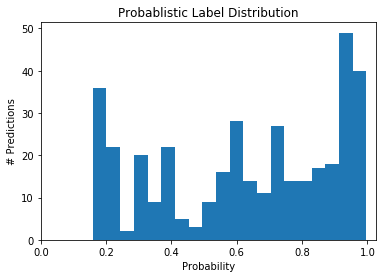

In [17]:
from  metal.contrib.visualization.analysis  import plot_probabilities_histogram

# Looking at probability histogram for training labels
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")

Using the development set, we can also check that the class balance of our weak labels if we were to naively binarize at the 0.5 cutoff -- we see reasonable behavior here.

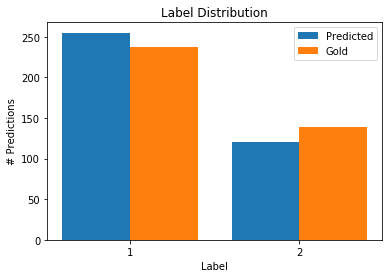

In [18]:
from metal.contrib.visualization.analysis import plot_predictions_histogram
# Obtaining binarized predictions
Y_dev_p = label_model.predict(Ls[1])
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Step 6: Train a Weakly Supervised End Model

Now that we have our weak training labels, we can train a commodity CNN using a simple PyTorch API.  In Snorkel MeTaL, we have written high-level utilities to do this.  The entire process of defining and training the model can be executed in the following two simple cells.

First, we define PyTorch `DataLoader` objects to efficiently load our image data, associating each image with the weak label generated from its associated report.

In [19]:
import torch
from torchvision import models
from metal.end_model import EndModel
from metal.logging.tensorboard import TensorBoardWriter
from utils import get_data_loader

# Setting up log directory
log_config = {"log_dir": "./run_logs", "run_name": 'openi_demo_ws'}
tuner_config = {"max_search": 1}
search_space = {
    "l2": [0.0005],  # linear range
    "lr": [0.001]
}

# Create pytorch model
num_classes = 2
cnn_model = models.resnet18(pretrained=True)
last_layer_input_size = int(cnn_model.fc.weight.size()[1])
cnn_model.fc = torch.nn.Linear(last_layer_input_size, num_classes)

# Create data loaders
loaders = {}
loaders['train'] = get_data_loader(data['train']['xray_paths'].tolist(), Y_ps[0], batch_size=32, shuffle=True)
loaders['dev'] = get_data_loader(data['dev']['xray_paths'].tolist(), Ys[1], batch_size=32, shuffle=False)
loaders['test'] = get_data_loader(data['test']['xray_paths'].tolist(), Ys[2], batch_size=32, shuffle=False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jdunnmon/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 104565012.36it/s]


As an example, a single datapoint yields an image like this:

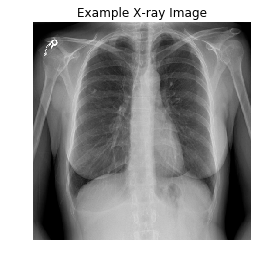

In [20]:
import matplotlib.pyplot as plt
img, label = loaders['train'].dataset[0]

plt.figure()
plt.imshow(img[0,:,:],cmap='gray')
plt.title('Example X-ray Image')
ax = plt.axis('off')

Now that our `DataLoaders` are set up, it is a simple matter to define and train our CNN model. 

Note: While this will run if you do not have a CUDA-based GPU available (and will automatically detect it if you do), it will proceed *much* faster if you have one!  CPU-only per-epoch training time is ~ 15 minutes, while with a Titan X it is approximately 30 s!

In [25]:
# Defining network parameters
num_classes = 2
pretrained = True
train_args = [loaders['train']]
init_args = [[num_classes]]

# Defining device variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initializing input module
input_module = cnn_model
init_kwargs = {"input_module": input_module, 
               "skip_head": True,
               "input_relu": False,
               "input_batchnorm": False,
               "device": device,
               'seed':1701}
train_kwargs = {'n_epochs': 5,
                'progress_bar':True}

# Setting up logger and searcher
searcher = RandomSearchTuner(EndModel, 
    **log_config, log_writer_class=TensorBoardWriter, 
    validation_metric='accuracy',
    seed=1701)

# Training weakly supervised model
weakly_supervised_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

A Jupyter Widget

[1 epo]: TRAIN:[loss=0.678] VALID:[accuracy=0.699]
Saving model at iteration 1 with best score 0.699



A Jupyter Widget

[2 epo]: TRAIN:[loss=0.654] VALID:[accuracy=0.684]



A Jupyter Widget

[3 epo]: TRAIN:[loss=0.652] VALID:[accuracy=0.681]



A Jupyter Widget

[4 epo]: TRAIN:[loss=0.649] VALID:[accuracy=0.710]
Saving model at iteration 4 with best score 0.710



A Jupyter Widget

[5 epo]: TRAIN:[loss=0.648] VALID:[accuracy=0.473]

Restoring best model from iteration 4 with score 0.710
Finished Training
Accuracy: 0.710
        y=1    y=2   
 l=1    214    23    
 l=2    86     53    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0005, 'lr': 0.001}
Best score: 0.7101063829787234


We can evaluate this model below, and see that we've learned some useful signal!  Remember that an Area Under the Receiver Operating Characteristic (ROC-AUC) score represents the probability across all possible cutoffs of ranking an abnormal example higher than a normal example.  If we've learned nothing useful, this value would be 0.5. 

You should expect a value just above 0.70 for this training run.

In [26]:
# Evaluating model
print (f"Evaluating Weakly Supervised Model")
scores = weakly_supervised_model.score(
    loaders['test'], metric=["roc-auc"]
)

Evaluating Weakly Supervised Model
Roc-auc: 0.713
        y=1    y=2   
 l=1    200    33    
 l=2    88     57    


## Step 7: Comparing to a Fully Supervised End Model

Because we have ground-truth labels for the entire dataset in this case (the OpenI dataset comes with these labels, which require physicians to label thousands of images!), we can compare how well our weakly supervised model does with the performance we achieve from a fully supervised model.  This is a similar analysis to that performed in our 2019 Nature submission.

Executing this requires a simple change to the training dataloader to provide it with ground-truth labels.

In [23]:
# Updating logging config
log_config = {"log_dir": "./run_logs", "run_name": 'openi_demo_fs'}


# Creating dataloader with ground truth training labels
loaders['full_train'] = get_data_loader(data['train']['xray_paths'].tolist(), Ys[0], batch_size=32, shuffle=True)
train_args = [loaders['full_train']]

# Setting up logger and searcher
searcher = RandomSearchTuner(EndModel, 
    **log_config, log_writer_class=TensorBoardWriter, 
    validation_metric='accuracy',
    seed=1701)

# Training                             
fully_supervised_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

A Jupyter Widget

[1 epo]: TRAIN:[loss=0.645] VALID:[accuracy=0.519]
Saving model at iteration 1 with best score 0.519



A Jupyter Widget

[2 epo]: TRAIN:[loss=0.582] VALID:[accuracy=0.686]
Saving model at iteration 2 with best score 0.686



A Jupyter Widget

[3 epo]: TRAIN:[loss=0.539] VALID:[accuracy=0.713]
Saving model at iteration 3 with best score 0.713



A Jupyter Widget

[4 epo]: TRAIN:[loss=0.527] VALID:[accuracy=0.652]



A Jupyter Widget

[5 epo]: TRAIN:[loss=0.503] VALID:[accuracy=0.638]

Restoring best model from iteration 3 with score 0.713
Finished Training
Accuracy: 0.713
        y=1    y=2   
 l=1    175    62    
 l=2    46     93    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0005, 'lr': 0.001}
Best score: 0.7127659574468085


Now, we can evaluate the weakly and fully supervised models, observing that they achieve similar Area Under the Receiver Operating Characteristic (ROC-AUC) scores.  Note that due to the small size of the dataset and that we are not tuning the cutoff for a particular performance score, we report ROC-AUC in this demo.

In [27]:
# Evaluating weakly model
print (f"Evaluating Weakly Supervised Model")
weakly_supervised_scores = weakly_supervised_model.score(
    loaders['test'], metric=["roc-auc"], print_confusion_matrix=False,
)

# Evaluating fully supervised model
print (f"Evaluating Fully Supervised Model")
fully_supervised_scores = fully_supervised_model.score(
    loaders['test'], metric=["roc-auc"], print_confusion_matrix=False,
)

Evaluating Weakly Supervised Model
Roc-auc: 0.713
Evaluating Fully Supervised Model
Roc-auc: 0.734


If the models have trained successfully, you should observe that the weakly and fully supervised models both achieve ROC-AUC scores around 0.70.  This indicates that the weak labels we created using our labeling functions over the text have successfully allowed us to train a CNN model that performs very similarly to one trained using ground truth, but *without having to label thousands of images*.

Congratulations! You've just trained a deep learning model using cross-modal data programming!  We hope this demo is helpful in your research, and check for updates to Snorkel and Snorkel MeTaL at [snorkel.stanford.edu](snorkel.stanford.edu)!